In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
import os

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
# Add the parent directory to the Python path
sys.path.append(os.path.abspath(".."))

In [3]:
from power_prediction.preprocess_data import get_data_interpolate_nan
from power_prediction.plotting_functions import *
from power_prediction.util import split_data_train_test

In [4]:
tqdm.pandas()

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [6]:
df = get_data_interpolate_nan()

In [7]:
# Drop unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


In [8]:
df.head()

,Date,Value_NE5,Value_NE7,Hr [%Hr],RainDur [min],StrGlo [W/m2],T [°C],WD [°],WVs [m/s],WVv [m/s],p [hPa],Vacation,Holiday,Year,Month,Day,Hour,Weekday,NE_tot,Corona
0,2015-01-01 00:00:00,65674.7507,135628.059644,89.25,0.0,0.02,-2.09,20.41,1.40,1.40,982.80,1.0,1.0,2015,1,1,0,4,201302.810344,0
1,2015-01-01 01:00:00,88747.5885,172742.750946,90.47,0.0,0.01,-2.48,353.85,0.61,0.60,982.64,1.0,1.0,2015,1,1,1,4,261490.339446,0
2,2015-01-01 02:00:00,86864.5321,173541.200194,89.45,0.0,0.02,-2.46,21.48,1.31,1.31,983.00,1.0,1.0,2015,1,1,2,4,260405.732294,0
3,2015-01-01 03:00:00,84158.7339,162802.863240,89.20,0.0,0.02,-2.63,12.22,1.70,1.66,982.93,1.0,1.0,2015,1,1,3,4,246961.597140,0
4,2015-01-01 04:00:00,81133.3041,154123.513780,89.56,0.0,0.02,-2.77,8.30,1.23,1.21,983.03,1.0,1.0,2015,1,1,4,4,235256.817880,0


In [9]:
# Drop Date_format, NE5 and NE7
df.drop(columns=['Value_NE5', 'Value_NE7'], inplace=True)

In [10]:
# set date as index
df.set_index('Date', inplace=True)

Check target variable

In [11]:
print(df['NE_tot'].head())

Date
2015-01-01 00:00:00    201302.810344
2015-01-01 01:00:00    261490.339446
2015-01-01 02:00:00    260405.732294
2015-01-01 03:00:00    246961.597140
2015-01-01 04:00:00    235256.817880
Name: NE_tot, dtype: float64


## Resample from hourly to daily

In [12]:
# Resample the target variable by summing over each day
daily_NE_tot = df['NE_tot'].resample('D').sum()
daily_rainDur = df[ 'RainDur [min]'].resample('D').sum()
print(daily_NE_tot.head())
print(daily_rainDur.head())

Date
2015-01-01    6.656837e+06
2015-01-02    7.068360e+06
2015-01-03    7.148798e+06
2015-01-04    6.728075e+06
2015-01-05    8.574335e+06
Freq: D, Name: NE_tot, dtype: float64
Date
2015-01-01      0.00
2015-01-02    445.76
2015-01-03    485.46
2015-01-04    147.78
2015-01-05      0.00
Freq: D, Name: RainDur [min], dtype: float64


In [13]:
# List of columns to average
mean_columns = ['T [°C]', 'Hr [%Hr]', 'StrGlo [W/m2]']

# Resample these columns by taking the mean
daily_mean = df[mean_columns].resample('D').mean()

print(daily_mean.head())

              T [°C]   Hr [%Hr]  StrGlo [W/m2]
Date                                          
2015-01-01 -1.867917  87.891250      20.547083
2015-01-02  0.705833  91.651250      26.652500
2015-01-03  4.912083  92.130833      15.165000
2015-01-04  4.861250  78.559167      47.625833
2015-01-05  0.961250  80.101250      84.143333


In [14]:
# Convert categorical columns to numerical (0 and 1)
df['Vacation'] = df['Vacation'].astype(int)
df['Holiday'] = df['Holiday'].astype(int)
df['Corona'] = df['Corona'].astype(int)

# Resample these columns by taking the maximum
daily_max = df[['Vacation', 'Holiday', 'Corona']].resample('D').max()


In [15]:
# For 'Weekday', the first value of the day
daily_weekday = df['Weekday'].resample('D').first()

Combine Resampled Data

In [16]:
# Combine all resampled data into a single DataFrame
df = pd.concat([daily_NE_tot, daily_rainDur, daily_mean, daily_max, daily_weekday], axis=1)

In [17]:
df.head()

,NE_tot,RainDur [min],T [°C],Hr [%Hr],StrGlo [W/m2],Vacation,Holiday,Corona,Weekday
Date,,,,,,,,,
2015-01-01,6.656837e+06,0.00,-1.867917,87.891250,20.547083,1,1,0,4
2015-01-02,7.068360e+06,445.76,0.705833,91.651250,26.652500,1,1,0,5
2015-01-03,7.148798e+06,485.46,4.912083,92.130833,15.165000,1,0,0,6
2015-01-04,6.728075e+06,147.78,4.861250,78.559167,47.625833,0,0,0,7
2015-01-05,8.574335e+06,0.00,0.961250,80.101250,84.143333,0,0,0,1


In [18]:
# Check for missing values
print(df.isnull().sum())

NE_tot           0
RainDur [min]    0
T [°C]           0
Hr [%Hr]         0
StrGlo [W/m2]    0
Vacation         0
Holiday          0
Corona           0
Weekday          0
dtype: int64


In [19]:
# Reset index to access 'Date' as a column
df = df.reset_index()

# Extract date components
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['IsWeekend'] = df['Weekday'].isin([5,6]).astype(int)

# Set 'Date' back as index
df.set_index('Date', inplace=True)


In [20]:
df.head(10)

,NE_tot,RainDur [min],T [°C],Hr [%Hr],StrGlo [W/m2],Vacation,Holiday,Corona,Weekday,Year,Month,Day,IsWeekend
Date,,,,,,,,,,,,,
2015-01-01,6.656837e+06,0.00,-1.867917,87.891250,20.547083,1,1,0,4,2015,1,1,0
2015-01-02,7.068360e+06,445.76,0.705833,91.651250,26.652500,1,1,0,5,2015,1,2,1
2015-01-03,7.148798e+06,485.46,4.912083,92.130833,15.165000,1,0,0,6,2015,1,3,1
2015-01-04,6.728075e+06,147.78,4.861250,78.559167,47.625833,0,0,0,7,2015,1,4,0
2015-01-05,8.574335e+06,0.00,0.961250,80.101250,84.143333,0,0,0,1,2015,1,5,0
2015-01-06,8.718944e+06,0.00,0.296111,84.402083,75.700833,0,0,0,2,2015,1,6,0
2015-01-07,8.688718e+06,0.37,2.377917,79.210417,52.186667,0,0,0,3,2015,1,7,0
2015-01-08,8.663349e+06,203.45,5.643750,72.328333,44.120833,0,0,0,4,2015,1,8,0
2015-01-09,8.643280e+06,166.60,8.466667,71.488333,16.731667,0,0,0,5,2015,1,9,1


### Plot prepared data

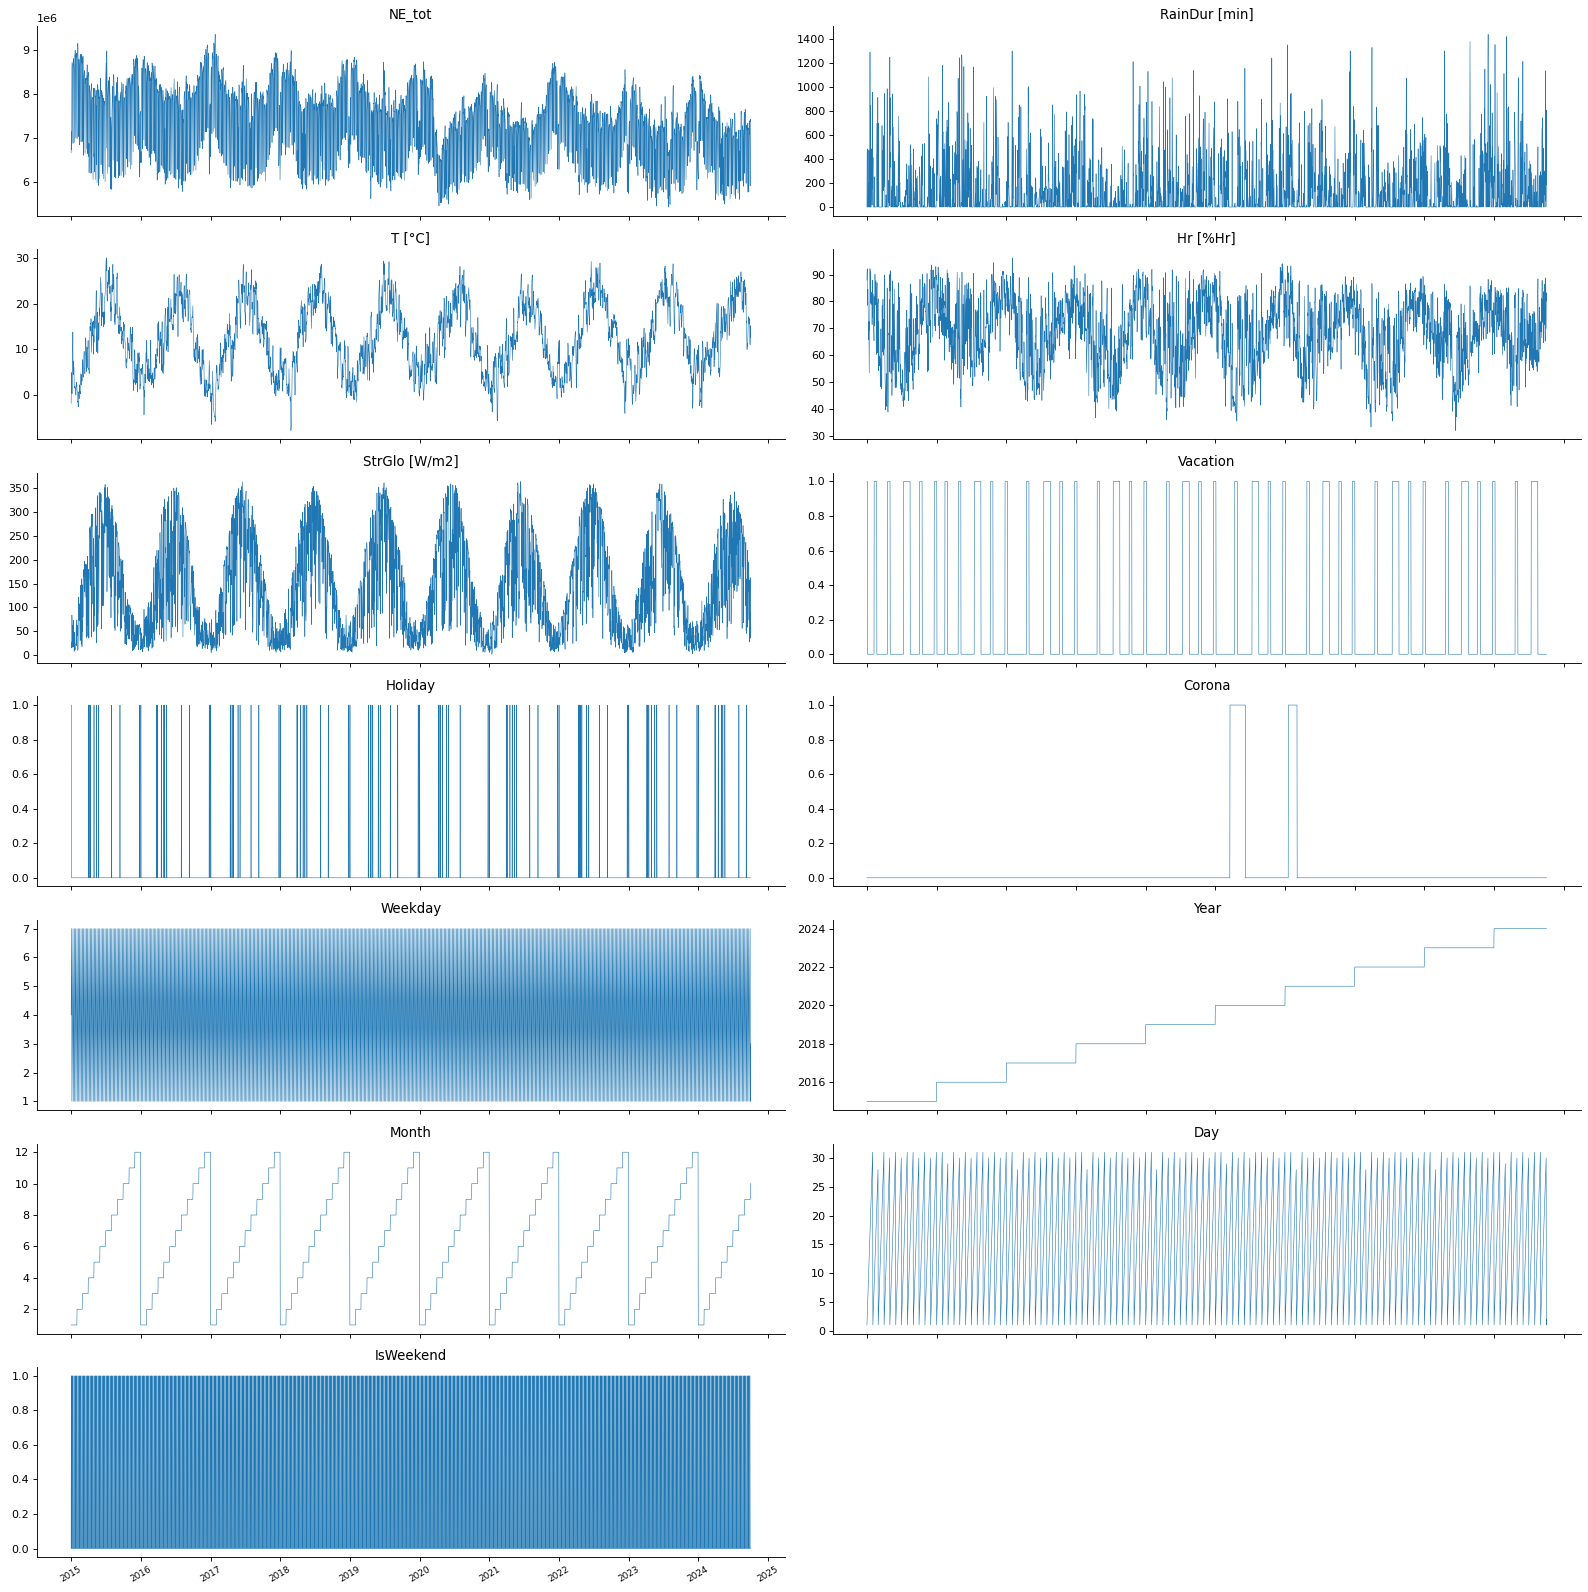

In [21]:
def data_plot(df, sample_interval=1):
    # Sample the DataFrame
    df_plot = df.iloc[::sample_interval, :]  # Adjust the interval as needed

    ncols = 2
    nrows = int(np.ceil(df_plot.shape[1] / ncols))  # Ensure enough rows

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, 20), dpi=80)
    ax = ax.flatten()  # Flatten the array for easy indexing

    for i, col in enumerate(df_plot.columns):
        ax[i].plot(df_plot.index, df_plot[col], linewidth=0.5)
        ax[i].tick_params(axis="x", rotation=30, labelsize=8)
        ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
        ax[i].set_title(col)
        # Remove top and right spines for aesthetics and performance
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

    # Hide any unused subplots
    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])

    fig.tight_layout()
    plt.show()
    
# Plot the data
data_plot(df)


In [22]:
# Get the latest date in the dataset
latest_date = df.index.max()

latest_date

Timestamp('2024-10-02 00:00:00')

In [23]:
# Calculate the date one year prior
one_year_ago = latest_date - pd.DateOffset(years=1)

In [24]:
# Split the data into training and test set
# Training data: all data up to one year ago
train_df = df[df.index <= one_year_ago]

# Testing data: all data after one year ago
test_df = df[df.index > one_year_ago]

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (3197, 13)
Testing data shape: (366, 13)


In [25]:

input_scaler = StandardScaler()
target_scaler = StandardScaler()

In [26]:
# Define the target feature
target_feature = 'NE_tot'

# Define input features
input_features = df.columns.drop(target_feature).tolist()

In [27]:
# Fit the scaler
input_scaler.fit(train_df[input_features])
target_scaler.fit(train_df[[target_feature]])

StandardScaler()

In [28]:
# Transform the input features
X_train_scaled = input_scaler.transform(train_df[input_features])
X_test_scaled = input_scaler.transform(test_df[input_features])

# Transform the target variable
y_train_scaled = target_scaler.transform(train_df[[target_feature]])
y_test_scaled = target_scaler.transform(test_df[[target_feature]])


In [29]:
# Convert scaled inputs back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, index=train_df.index, columns=input_features)
X_test_scaled = pd.DataFrame(X_test_scaled, index=test_df.index, columns=input_features)

# Convert scaled targets back to DataFrames
y_train_scaled = pd.DataFrame(y_train_scaled, index=train_df.index, columns=[target_feature])
y_test_scaled = pd.DataFrame(y_test_scaled, index=test_df.index, columns=[target_feature])

## Prepare Data for LSTM Input

In [30]:
sequence_length = 50


In [31]:
def create_sequences(inputs, targets, sequence_length):
    Xs, ys = [], []
    for i in range(len(inputs) - sequence_length):
        Xs.append(inputs.iloc[i:(i + sequence_length)].values)
        ys.append(targets.iloc[i + sequence_length].values)
    return np.array(Xs), np.array(ys)

# Create sequences for training data
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, sequence_length)

# Create sequences for testing data
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, sequence_length)


In [32]:
# Convert to PyTorch tensors and transfer to device
X_train = torch.from_numpy(X_train).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)

X_test = torch.from_numpy(X_test).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)


In [33]:
# Create a TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders with a smaller batch size
batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Define the LSTM Model

In [34]:
# Modify the LSTMModel class
class LSTMModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = False  # Set bidirectional to False

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2,
            bidirectional=self.bidirectional
        )

        self.fc = nn.Linear(hidden_size, 1)  # Adjust input size accordingly

    def forward(self, x):
        device = x.device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Take output from the last time step
        out = self.fc(out)
        return out


In [35]:
# Instantiate the model
input_size = X_train.shape[2]  # Number of input features
hidden_size = 128             
num_layers = 4                

model = LSTMModel(input_size, hidden_size, num_layers).to(device)

In [36]:
# Update the loss function
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [37]:
# Adjusted Training Loop with Loss Recording
num_epochs = 75
training_loss = []
validation_loss = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    training_loss.append(avg_train_loss)

    # Validation Loop
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch)
            val_loss = criterion(output, y_batch)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    validation_loss.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1/75], Train Loss: 0.3679, Val Loss: 0.2758
Epoch [2/75], Train Loss: 0.2250, Val Loss: 0.1201
Epoch [3/75], Train Loss: 0.0862, Val Loss: 0.0843
Epoch [4/75], Train Loss: 0.0719, Val Loss: 0.0852
Epoch [5/75], Train Loss: 0.0637, Val Loss: 0.0714
Epoch [6/75], Train Loss: 0.0606, Val Loss: 0.0718
Epoch [7/75], Train Loss: 0.0584, Val Loss: 0.0690
Epoch [8/75], Train Loss: 0.0548, Val Loss: 0.0708
Epoch [9/75], Train Loss: 0.0530, Val Loss: 0.0722
Epoch [10/75], Train Loss: 0.0515, Val Loss: 0.1102
Epoch [11/75], Train Loss: 0.0497, Val Loss: 0.1116
Epoch [12/75], Train Loss: 0.0482, Val Loss: 0.1076
Epoch [13/75], Train Loss: 0.0458, Val Loss: 0.1234
Epoch [14/75], Train Loss: 0.0424, Val Loss: 0.0969
Epoch [15/75], Train Loss: 0.0415, Val Loss: 0.0635
Epoch [16/75], Train Loss: 0.0397, Val Loss: 0.0659
Epoch [17/75], Train Loss: 0.0383, Val Loss: 0.0905
Epoch [18/75], Train Loss: 0.0353, Val Loss: 0.0853
Epoch [19/75], Train Loss: 0.0355, Val Loss: 0.0850
Epoch [20/75], Train 

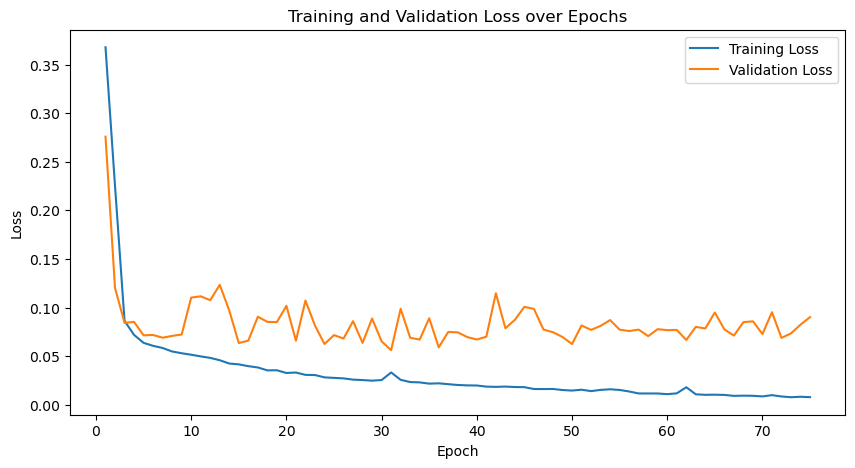

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

## Evaluate the Model

In [39]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_train_pred = model(X_train).cpu().numpy()
    y_test_pred = model(X_test).cpu().numpy()


# Inverse transform the scaled target predictions using target_scaler
y_train_actual = target_scaler.inverse_transform(y_train.cpu().numpy())
y_train_pred = target_scaler.inverse_transform(y_train_pred)

y_test_actual = target_scaler.inverse_transform(y_test.cpu().numpy())
y_test_pred = target_scaler.inverse_transform(y_test_pred)



In [40]:

def evaluate_metrics(y_actual, y_pred, dataset_name=""):
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    
    # Handle division by zero in MAPE calculation
    y_actual_nonzero = np.where(y_actual == 0, 1e-10, y_actual)
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual_nonzero)) * 100
    
    print(f"Metrics for {dataset_name}:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}%\n")

In [41]:
# Evaluate metrics on the training set
evaluate_metrics(y_train_actual, y_train_pred, "Training Set")

# Evaluate metrics on the test set
evaluate_metrics(y_test_actual, y_test_pred, "Test Set")

Metrics for Training Set:
  Mean Squared Error (MSE): 7263451648.0000
  Mean Absolute Error (MAE): 64982.8594
  R-squared (R²): 0.9886
  Mean Absolute Percentage Error (MAPE): 0.88%

Metrics for Test Set:
  Mean Squared Error (MSE): 124113526784.0000
  Mean Absolute Error (MAE): 259148.5000
  R-squared (R²): 0.7436
  Mean Absolute Percentage Error (MAPE): 3.70%



In [42]:
dates = test_dates(test_df, y_test_actual)

In [43]:
def line_plot_pred(dates, y_actual, y_pred):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    y_actual = y_actual.flatten()
    y_pred = y_pred.flatten()

    y_test_scaled_down = y_actual / 1e9
    y_pred_scaled_down = y_pred / 1e9


    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Date': dates,
        'Actual': y_actual,
        'Predicted': y_pred
    })

    # Set the figure size
    plt.figure(figsize=(15, 5))

    # Plot the actual and predicted values
    sns.lineplot(x='Date', y='Actual', data=plot_df, label='Actual', linewidth=2.5, alpha=0.7)
    sns.lineplot(x='Date', y='Predicted', data=plot_df, label='Predicted', linewidth=2)

    # Add title and labels
    plt.title('Electricity Consumption Prediction', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Electricity Consumption')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display legend
    plt.legend()

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Show the plot
    plt.show()


In [44]:
def line_plot_pred1(dates, y_actual, y_pred):
    """
    :param dates: DatetimeIndex generated by test_dates function
    :param y_actual: y_test data
    :param y_pred: the predicted data
    """
    y_actual = y_actual.flatten()
    y_pred = y_pred.flatten()
    
    y_actual_scaled_down = y_actual / 1e6
    y_pred_scaled_down = y_pred / 1e6

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Date': dates,
        'Actual': y_actual_scaled_down,
        'Predicted': y_pred_scaled_down
    })

    # Set the figure size
    plt.figure(figsize=(15, 5))

    # Plot the actual and predicted values
    sns.lineplot(x='Date', y='Actual', data=plot_df, label='Actual', linewidth=2.5, alpha=0.7)
    sns.lineplot(x='Date', y='Predicted', data=plot_df, label='Predicted', linewidth=2)

    # Add title and labels
    plt.title('Power Consumption in Zurich', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Power Consumption [GWh]', fontsize=14)


    plt.ticklabel_format(style='plain', axis='y')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

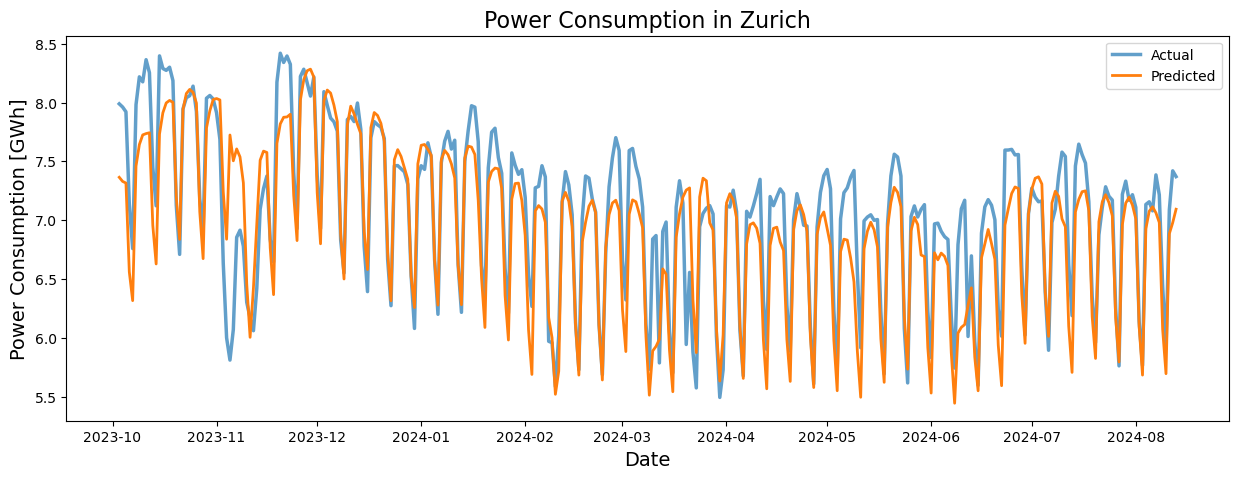

In [45]:
line_plot_pred1(dates, y_test_actual, y_test_pred)

In [47]:
from power_prediction.mlops_framework import *

In [ ]:
save